# Exploring the NASA Rotor 37 dataset

The goal of this notebook is to explore and understand the structure of the Rotor 37 dataset. We retrieved the data on the PLAID website [here](https://plaid-lib.readthedocs.io/en/latest/source/data_challenges/rotor37.html).

The goal of this notebook is to explore the variables given in dataset. 
- The cloudpoints of a blade
- Two input scalars: P and Omega
- Three outputs scalars: Massflow, Compression Ratio, Efficiency
- Three outputs fields: Density, Pressure, Temperature

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

# Importing the data
In this section we provide the code to import and view the data.

In [1]:
## Needed to import the data
import h5py
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sinkhorn

In [2]:
## Define functions to explore the .cgns file
def explore_cgns_structure(file_path):
    with h5py.File(file_path, 'r') as f:
        print("File structure:")
        explore_group(f)

def explore_group(group, indent=""):
    for key in group.keys():
        print(f"{indent}{key}")
        if isinstance(group[key], h5py.Group):
            explore_group(group[key], indent + "  ")


## Explore the veyy first blade .cgns file
number = '000000001'
explore_cgns_structure(f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns')

File structure:
 format
 hdf5version
Base_2_3
   data
  Time
     data
    IterationValues
       data
    TimeValues
       data
  Zone
     data
    ZoneType
       data
    GridCoordinates
      CoordinateX
         data
      CoordinateY
         data
      CoordinateZ
         data
    Elem_Quads
       data
      ElementRange
         data
      ElementConnectivity
         data
    VertexFields
      GridLocation
         data
      Density
         data
      Pressure
         data
      Temperature
         data
      NormalsX
         data
      NormalsY
         data
      NormalsZ
         data
    CellCenterFields
      GridLocation
         data
      Density
         data
      Pressure
         data
      Temperature
         data
      NormalsX
         data
      NormalsY
         data
      NormalsZ
         data
CGNSLibraryVersion
   data


We are interested in the coordonates of the cloud points. Lets define a function that can retrieve a cloud points from a .cgns file and the associated aero coefficient.

In [3]:
def read_cgns_coordinates(file_path):
    with h5py.File(file_path, 'r') as file:
        # We retrieve coordinate by coordinate.
        # ! Notice the space before the data. This is due to the naming in the files themselves.
        x = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateX'].get(' data'))
        y = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateY'].get(' data'))
        z = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateZ'].get(' data'))

    return x, y, z

Now we can import any number of blades with their aerodynamic coefficients.

In [4]:
## Number of blade one want to consider.
_many_blades = 10

## Creating the list of all file numbers.
padded_numbers = [str(i).zfill(9) for i in range(_many_blades)]

## Lists that will holds the cloud points and the associated efficiency.
distributions = []
efficiency = []
P = []
omega = []

for number in padded_numbers:
    ## File paths
    cgns_file_path = f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    coefficient_file_path = f'Rotor37/dataset/samples/sample_{number}/scalars.csv'

    ## Computing the coordinates
    x, y, z = read_cgns_coordinates(cgns_file_path)
    blade = np.column_stack((x, y, z))

    ## Computing the coefficient
    scalars = pd.read_csv(coefficient_file_path)
    
    ## Adding to our data
    distributions.append(blade)
    efficiency.append(scalars["Efficiency"][0])
    omega.append(scalars["Omega"][0])
    P.append(scalars["P"][0])

# Plotting blades

## Static plot

<Figure size 640x480 with 0 Axes>

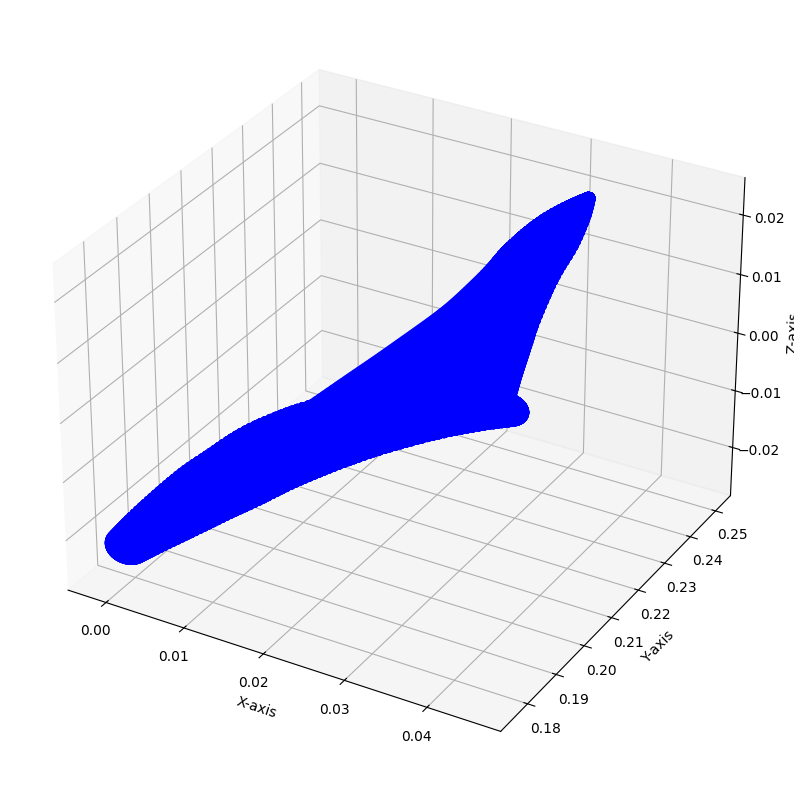

In [5]:
## Lets consider the very first blade
my_blade = distributions[0]

# Unpack the blade into separate arrays for x, y and z
x, y, z = my_blade[:, 0], my_blade[:, 1], my_blade[:, 2]

plt.figure()
# Create a DataFrame for Seaborn (not necessary for this example)
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Create 3D scatter plot with Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, s=50, c='blue', marker='o')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Save the figure
#plt.savefig("Images/blade_static_plot.png", dpi=300, bbox_inches='tight', format="png")

# Show the plot
plt.show()

## Dynamic plot

In [6]:
## Lets consider the very first blade
my_blade = distributions[0]

# Unpack the blade into separate arrays for x, y and z
x, y, z = my_blade[:, 0], my_blade[:, 1], my_blade[:, 2]

plt.figure()
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=1, color='blue'))])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# To export the plot
#fig.write_html("blade_plotly_figure.html")

# Show the plot
fig.show()

<Figure size 640x480 with 0 Axes>

## Clean plot for screenshots

In [7]:
fig.update_layout(scene=dict(aspectmode='data', xaxis_visible=False, yaxis_visible=False, zaxis_visible=False),
                 width=1100,  # Adjust width to increase resolution
                 height=1100,
                 legend=dict(x=0.4, y=0.88, xanchor='left', yanchor='top', 
                              font=dict(size=14),  # Adjust legend text size
                              bgcolor='rgba(255, 255, 255, 0.5)',  # Set legend background color and opacity
                              bordercolor='rgba(0, 0, 0, 0.5)',  # Set legend border color and opacity
                              borderwidth=0.3,  # Set legend border width
                              ))

## Plots with a reference measure

In [8]:
# Define the reference measure. Possibilities are "blade0", "disk", "sphere", "UniformSphere".
reference_measure = sinkhorn.define_reference_measure(data = np.array(distributions), ref_measure = "disk", ref_measure_size = 1000)

# Unpack the blade into separate arrays for x, y and z
second_blade = distributions[1]
x1, y1, z1 = second_blade[:, 0], second_blade[:, 1], second_blade[:, 2]
plt.figure()

# Create 3D scatter plot
trace2 = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=1, color='blue'))
trace1 = go.Scatter3d(x=reference_measure[:, 0], y=reference_measure[:, 1], z=reference_measure[:, 2], mode='markers', marker=dict(size=2, color='red'))
fig = go.Figure(data=[trace1, trace2])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data', xaxis_visible=False, yaxis_visible=False, zaxis_visible=False),
                 width=1100,  # Adjust width to increase resolution
                 height=1100,showlegend=False
                 )

# Show the plot
fig.show()

<Figure size 640x480 with 0 Axes>